1. Download the Dataset
Steps: 
    #1 Install required libraries
    #2 Download data from Kaggle
    #3 View dataset files
    #4 Load Training set with Pandas
    #5 Load test set with Pandas

In [8]:
# Our Training Data is huge so We are going to just take 1M of 55M rows to train our model.

import pandas as pd
import numpy as np

train_df = pd.read_csv("train1M.csv")
submission_df = pd.read_csv("sample_submission.csv")

Observations:
    # This is a supervised learning regression problem
    # Training Data is 5.5GB in size
    # Training Data has 55 M rows.
    # Test set is much smaller (<10000 rows)
    # The training set has 8 Columns:
        # key
        # fare_amount
        # pickup_datetime
        # pickup_longitude
        # dropoff_longitudde
        # dropoff_latitude
        # passenger_count
    # The test set has all columns except the target column fare_amount
    # The submission file should contain only the key and fare_amount for each test sample

Loading Training Set

TIP #2: When working with large datasets, always start with a sample to experiment & iterate faster.

Loading the entire dataset into Pandas is going to be slow, so we can use the following optimizations:
    # Ignore the key column
    # Parse pickup datetime while loading data
    # Specify data types for other columns
        ## float32 for geo coordinates
        ## float32 for fare amount
        ## uint8 for passenger count
    # Work with a 1% sample of the data(~550k rows)

We can apply these optimizations while using pd.read_csv

In [9]:
import random

In [10]:
selected_cols = ['fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count']

dtypes = {
    'fare_amount':'float32', 'pickup_longitude':'float32',
       'pickup_latitude':'float32', 'dropoff_longitude':'float32', 'dropoff_latitude':'float32',
       'passenger_count':'uint8'
}

sample_fraction = 0.01
def skip_row(row_idx): ## Haven't Used here because i already trimmed my data to have 1M rows But in future we can use this method
    if row_idx == 0:
        return False
    return random.random() > sample_fraction

random.seed(42) # Tip #3: Fix the seeds for random number generators so that you get the same results every time you run your notebook
df = pd.read_csv("train1M.csv", usecols=selected_cols, parse_dates=['pickup_datetime'], dtype=dtypes) # just add skiprows=skip_row to use

In [11]:
test_df = pd.read_csv("test.csv", dtype=dtypes, parse_dates=['pickup_datetime'])

## 2. Explore the Dataset

- Basic info about training set
- Basic info about test set
- Exploratory data analysis & visualization
- Ask & answer questions

Training set

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   fare_amount        1000000 non-null  float32            
 1   pickup_datetime    1000000 non-null  datetime64[ns, UTC]
 2   pickup_longitude   1000000 non-null  float32            
 3   pickup_latitude    1000000 non-null  float32            
 4   dropoff_longitude  999994 non-null   float32            
 5   dropoff_latitude   999994 non-null   float32            
 6   passenger_count    1000000 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 27.7 MB


In [13]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999994.000000,999994.000000,1000000.000000
mean,11.340533,-72.509201,39.913731,-72.502945,39.911041,1.684381
std,9.795461,14.742901,10.682484,14.002069,12.138976,1.339930
min,-145.000000,-3408.458740,-3430.761230,-3379.110596,-3493.651855,0.000000
25%,6.000000,-73.992050,40.734940,-73.991394,40.734001,1.000000
50%,8.500000,-73.981766,40.752728,-73.980156,40.753136,1.000000
75%,12.500000,-73.966957,40.767208,-73.963669,40.768089,2.000000
max,475.000000,2817.293457,3306.747559,3382.125732,3537.132568,208.000000


In [14]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2009-01-01 00:06:48+0000', tz='UTC'),
 Timestamp('2015-06-30 23:47:38+0000', tz='UTC'))

Observations about training data:
    # 1M rows
    # 6 missing data for dropoff long/lat
    # fare_Amount ranges from -145 to 475
    # passenger_count ranges from 0 to 208
    # There seems to be some errors in the latitude and longitude values
    # Dates range from 1st Jan 2009 to 30th June 2015
    # The Dataset takes up ~28MB of space in RAM.
We may need to deal with outliers and data entry errors before we train our model.

Test Set

In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


In [16]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974724,40.751041,-73.973663,40.751740,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


In [17]:
test_df['pickup_datetime'].min(), test_df['pickup_datetime'].max()

(Timestamp('2009-01-01 11:04:24+0000', tz='UTC'),
 Timestamp('2015-06-30 20:03:50+0000', tz='UTC'))

Some observations about the test set:

    # 9914 rows of data
    # No missing values
    # No obvious data entry errors
    # 1 to 6 passengers
    # Latitudes lie between 40 and 42
    # Longitudes lie between -72 and -75
    # Pickup dates range from Jan 1st 2019 to Jun 30th 2015 (same as training set)
We can use the ranges of the test set to drop outliers/invalid data from  the training set.

### Exploratory Data Analysis and Visualization

**Exercise**: Create graphs (histograms, line charts, bar charts, scatter plots, box plots, geo maps etc.) to study the distrubtion of values in each column, and the relationship of each input column to the target.


### Ask & Answer Questions

**Exercise**: Ask & answer questions about the dataset: 

1. What is the busiest day of the week?
2. What is the busiest time of the day?
3. In which month are fares the highest?
4. Which pickup locations have the highest fares?
5. Which drop locations have the highest fares?
6. What is the average ride distance?

EDA + asking questions will help you develop a deeper understand of the data and give you ideas for feature engineering.

Resources for exploratory analysis & visualization:

- EDA project from scratch: https://www.youtube.com/watch?v=kLDTbavcmd0
- Data Analysis with Python: https://zerotopandas.com

TIP #4: Take an iterative approach to building ML models: do some EDA, do some feature engineering, train a model, then repeat to improve your model.

## 3. Prepare Dataset for Training

- Split Training & Validation Set
- Fill/Remove Missing Values
- Extract Inputs & Outputs
   - Training
   - Validation
   - Test

### Split Training & Validation Set

We'll set aside 20% of the training data as the validation set, to evaluate the models we train on previously unseen data. 

Since the test set and training set have the same date ranges, we can pick a random 20% fraction.

TIP #5: Your Validation set should be similar to the test set or real-world data as possible i.e. the evaluation metric score of a model on validation & test sets should be very close, otherwise you're shooting in the dark.


In [18]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state =42)
len(train_df), len(val_df)

(800000, 200000)

### Fill/Remove Missing Values

There are no missing values in our sample, but if there were, we could simply drop the rows with missing values instead of trying to fill them (since we have a lot of training data)

In [19]:
train_df = train_df.dropna()
val_df = val_df.dropna()

### Extract Inputs and Outputs

In [20]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [21]:
input_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
target_col = 'fare_amount'

#### Training,Validation and Test Data sets

In [22]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]
test_inputs = test_df[input_cols]

### Train & Evaluate Baseline Model

TIP#6: Always create a baseline model to establish the minimum score any proper ML model should beat.

We'll train a linear regression model as our baseline, which tries to express the target as a weighted sum of the inputs.

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
linear_model = LinearRegression().fit(train_inputs, train_targets)


In [24]:
train_preds = linear_model.predict(train_inputs)
train_preds

array([11.327659 , 11.3277855, 11.327732 , ..., 11.327651 , 11.327589 ,
       11.327725 ], shape=(799996,), dtype=float32)

In [25]:
val_preds = linear_model.predict(val_inputs)
val_preds

array([11.3276005, 11.327721 , 11.327635 , ..., 11.327705 , 11.327586 ,
       11.327653 ], shape=(199998,), dtype=float32)

In [26]:
train_rmse = root_mean_squared_error(train_targets, train_preds)
train_rmse

9.774323463439941

In [27]:
val_rmse = root_mean_squared_error(val_targets, val_preds)
val_rmse

9.877792358398438

The linear regression model is off by $9.898, which isn't much better than simply predicting the average. 

This is mainly because the training data (geocoordinates) is not in a format that's useful for the model, and we're not using one of the most important columns: pickup date & time.

However, now we have a baseline that our other models should ideally beat.

## 5. Make Predictions and Submit to Kaggle

TIP #7: When working on a Kaggle Competition, submit early and submit often (ideally daily). The best way to improve your models is to try & beat your previous score.

- Make predictions for test set
- Generate submissions CSV
- Submit to Kaggle
- Record in experiment tracking sheet

In [29]:
test_preds = linear_model.predict(test_inputs)
submission_df = pd.read_csv('sample_submission.csv')

# TIP #8: Create reusable functions for common tasks. They will help you iterate faster and free up your mind to think about new ideas.

In [28]:
def predict_and_submit(model, test_inputs, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv("sample_submission.csv")
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)
    return sub_df

In [ ]:
predict_and_submit(linear_model, test_inputs, 'linear_sub.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.327710
1,2015-01-27 13:08:24.0000003,11.327677
2,2011-10-08 11:53:44.0000002,11.327702
3,2012-12-01 21:12:12.0000002,11.327642
4,2012-12-01 21:12:12.0000003,11.327680
...,...,...
9909,2015-05-10 12:37:51.0000002,11.327674
9910,2015-01-12 17:05:51.0000001,11.327706
9911,2015-04-19 20:44:15.0000001,11.328575
9912,2015-01-31 01:05:19.0000005,11.327679


 # TIP #9: Track your ideas and experiments systematically to avoid become overwhelmed with dozens of models. Use this template: https://bit.ly/mltrackingsheet

## 6. Feature Engineering

# TIP #10: Take an iterative approach to feature engineering. Add some features, train a model, evaluate it, keep the features if they help, otherwise drop them, then repeat.

- Extract parts of date
- Remove outliers & invalid data
- Add distance between pickup & drop
- Add distance from landmarks

Exercise: We're going to apply all of the above together, but you should observe the effect of adding each feature individually.

### Extract Parts of Date

- Year
- Month
- Day
- Weekday
- Hour


In [30]:
def add_dateparts(df, col):
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour

In [31]:
add_dateparts(train_df, 'pickup_datetime')

In [32]:
add_dateparts(val_df, 'pickup_datetime')

In [33]:
add_dateparts(test_df, 'pickup_datetime')

In [ ]:
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
566853,4.100000,2010-12-26 04:23:27+00:00,-74.005638,40.726280,-74.003067,40.727558,1,2010,12,26,6,4
382311,8.000000,2014-07-26 16:04:09+00:00,-73.997772,40.713623,-73.977386,40.719261,2,2014,7,26,5,16
241519,3.500000,2014-03-20 08:47:00+00:00,-73.960922,40.772213,-73.948433,40.777966,1,2014,3,20,3,8
719220,21.299999,2012-07-10 06:09:53+00:00,-73.983475,40.738220,-73.887077,40.744785,1,2012,7,10,1,6
905718,4.500000,2010-09-11 07:03:30+00:00,-73.977798,40.777767,-73.974678,40.796749,1,2010,9,11,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...
259178,12.900000,2011-02-23 06:49:00+00:00,-73.976715,40.752659,-74.013748,40.714867,2,2011,2,23,2,6
365838,11.300000,2009-11-04 15:05:00+00:00,-73.984108,40.767197,-73.973083,40.758945,5,2009,11,4,2,15
131932,10.500000,2012-12-07 12:41:00+00:00,-73.984459,40.769131,-73.974129,40.764771,5,2012,12,7,4,12
671155,3.700000,2009-12-25 18:39:00+00:00,-73.993935,40.766895,-73.994057,40.759083,1,2009,12,25,4,18


### Add Distance Between Pickup and Drop

We can use the haversine distance: 
- https://en.wikipedia.org/wiki/Haversine_formula
- https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas

In [34]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [35]:
def add_trip_distance(df):
    df['trip_distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

In [36]:
add_trip_distance(train_df)
add_trip_distance(val_df)
add_trip_distance(test_df)

In [37]:
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
566853,4.100000,2010-12-26 04:23:27+00:00,-74.005638,40.726280,-74.003067,40.727558,1,2010,12,26,6,4,0.259169
382311,8.000000,2014-07-26 16:04:09+00:00,-73.997772,40.713623,-73.977386,40.719261,2,2014,7,26,5,16,1.827964
241519,3.500000,2014-03-20 08:47:00+00:00,-73.960922,40.772213,-73.948433,40.777966,1,2014,3,20,3,8,1.230283
719220,21.299999,2012-07-10 06:09:53+00:00,-73.983475,40.738220,-73.887077,40.744785,1,2012,7,10,1,6,8.149273
905718,4.500000,2010-09-11 07:03:30+00:00,-73.977798,40.777767,-73.974678,40.796749,1,2010,9,11,5,7,2.125563
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,12.900000,2011-02-23 06:49:00+00:00,-73.976715,40.752659,-74.013748,40.714867,2,2011,2,23,2,6,5.230756
365838,11.300000,2009-11-04 15:05:00+00:00,-73.984108,40.767197,-73.973083,40.758945,5,2009,11,4,2,15,1.304860
131932,10.500000,2012-12-07 12:41:00+00:00,-73.984459,40.769131,-73.974129,40.764771,5,2012,12,7,4,12,0.995467
671155,3.700000,2009-12-25 18:39:00+00:00,-73.993935,40.766895,-73.994057,40.759083,1,2009,12,25,4,18,0.868364


### Add Distance From Popular Landmarks

# TIP #11: Creative feature engineering (generally involving human insight or external data) is a lot more effective than excessive hyperparameter tuning. Just one or two good feature improve the model's performance drastically.

- JFK Airport
- LGA Airport
- EWR Airport
- Times Square
- Met Meuseum
- World Trade Center

We'll add the distance from drop location. 

In [38]:
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

In [39]:
def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])


In [40]:

for a_df in [train_df, val_df, test_df]:
    for name, lonlat in [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]:
        add_landmark_dropoff_distance(a_df, name, lonlat)

In [41]:
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
566853,4.100000,2010-12-26 04:23:27+00:00,-74.005638,40.726280,-74.003067,40.727558,1,2010,12,26,6,4,0.259169,21.242895,12.169916,15.047916,6.666843,1.759137
382311,8.000000,2014-07-26 16:04:09+00:00,-73.997772,40.713623,-73.977386,40.719261,2,2014,7,26,5,16,1.827964,18.897230,10.806078,16.931921,6.788441,2.837270
241519,3.500000,2014-03-20 08:47:00+00:00,-73.960922,40.772213,-73.948433,40.777966,1,2014,3,20,3,8,1.230283,20.892740,6.264265,21.424927,1.253356,8.918808
719220,21.299999,2012-07-10 06:09:53+00:00,-73.983475,40.738220,-73.887077,40.744785,1,2012,7,10,1,6,8.149273,14.715949,3.734265,24.976343,7.473476,10.944444
905718,4.500000,2010-09-11 07:03:30+00:00,-73.977798,40.777767,-73.974678,40.796749,1,2010,9,11,5,7,2.125563,23.927404,8.753200,20.617397,2.156101,9.809777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,12.900000,2011-02-23 06:49:00+00:00,-73.976715,40.752659,-74.013748,40.714867,2,2011,2,23,2,6,5.230756,21.476248,13.635836,13.833103,8.338512,0.410377
365838,11.300000,2009-11-04 15:05:00+00:00,-73.984108,40.767197,-73.973083,40.758945,5,2009,11,4,2,15,1.304860,20.994112,8.573982,18.636122,2.420064,6.011471
131932,10.500000,2012-12-07 12:41:00+00:00,-73.984459,40.769131,-73.974129,40.764771,5,2012,12,7,4,12,0.995467,21.470366,8.533307,18.833851,1.867278,6.533537
671155,3.700000,2009-12-25 18:39:00+00:00,-73.993935,40.766895,-73.994057,40.759083,1,2009,12,25,4,18,0.868364,22.412683,10.296119,17.050770,3.440767,5.334958


### Remove Outliers and Invalid Data

There seems to be some invalide data in each of the following columns:

- Fare amount
- Passenger count
- Pickup latitude & longitude
- Drop latitude & longitude

In [42]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,799996.000000,799996.000000,799996.000000,799996.000000,799996.000000,799996.000000,799996.000000,799996.000000,799996.000000,799996.000000,799996.000000,799996.000000,799996.000000,799996.000000,799996.000000,799996.000000,799996.000000
mean,11.337862,-72.511375,39.914463,-72.509796,39.911591,1.684607,2011.739535,6.262578,15.714534,3.042964,13.507075,20.259123,194.742691,183.960556,193.014801,179.006775,180.502350
std,9.774687,15.030275,11.337173,13.650185,13.008621,1.347442,1.860854,3.436320,8.684789,1.950012,6.516412,375.768585,1228.976807,1232.046509,1233.897461,1233.771729,1233.870117
min,-145.000000,-3408.458740,-3430.761230,-3379.110596,-3493.651855,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.237364,0.174454,0.167215,0.023781,0.011009
25%,6.000000,-73.992058,40.734917,-73.991379,40.733997,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.213727,20.538017,8.343552,16.506209,2.163866,3.644497
50%,8.500000,-73.981781,40.752735,-73.980164,40.753113,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.117039,21.205291,9.575130,18.021124,3.803126,5.567804
75%,12.500000,-73.966972,40.767178,-73.963684,40.768070,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.874549,21.951639,11.123270,19.957798,6.055930,7.822180
max,475.000000,2817.293457,3306.747559,2497.105713,3537.132568,208.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,18885.929688,16780.705078,16764.947266,16772.054688,16763.939453,16770.941406


In [43]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974724,40.751041,-73.973663,40.751740,1.671273,2011.815816,6.857979,16.194170,2.852834,13.467420,3.433215,20.916756,9.675180,18.546659,4.512898,6.037652
std,0.042774,0.033541,0.039072,0.035435,1.278747,1.803347,3.353272,8.838482,1.994451,6.868584,3.969883,3.303943,3.295647,4.035820,4.018428,4.252539
min,-74.252190,40.573143,-74.263245,40.568974,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.401900,0.285629,0.284680,0.085747,0.040269
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000,2010.000000,4.000000,9.000000,1.000000,8.000000,1.297261,20.513337,8.311565,16.520517,2.126287,3.670107
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,2012.000000,7.000000,16.000000,3.000000,15.000000,2.215648,21.181472,9.477797,18.024350,3.698123,5.541466
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,2014.000000,10.000000,25.000000,5.000000,19.000000,4.043051,21.909794,10.965272,19.880536,5.922544,7.757612
max,-72.986534,41.709557,-72.990967,41.696682,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,99.933281,134.497726,126.062576,149.400787,130.347153,138.619492


We'll use the following ranges:

- `fare_amount`: $1 to $500
- `longitudes`: -75 to -72
- `latitudes`: 40 to 42
- `passenger_count`: 1 to 6


In [44]:
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

In [45]:
train_df = remove_outliers(train_df)

In [46]:
val_df = remove_outliers(val_df)

In [47]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,780196.000000,780196.000000,780196.000000,780196.000000,780196.000000,780196.000000,780196.000000,780196.000000,780196.000000,780196.000000,780196.000000,780196.000000,780196.000000,780196.000000,780196.000000,780196.000000,780196.000000
mean,11.330057,-73.975136,40.751080,-73.974373,40.751354,1.690412,2011.737935,6.266374,15.710614,3.043107,13.507398,3.332861,20.912138,9.687975,18.473078,4.484536,5.964254
std,9.687690,0.039134,0.030009,0.038281,0.033115,1.306019,1.866367,3.437127,8.683626,1.950200,6.515767,3.812318,3.105902,3.080106,3.743534,3.794880,3.980999
min,1.200000,-74.974564,40.077644,-74.891312,40.059399,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.237364,0.174454,0.167215,0.023781,0.011009
25%,6.000000,-73.992271,40.736595,-73.991570,40.735542,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.254876,20.522022,8.317474,16.478961,2.134904,3.588503
50%,8.500000,-73.982086,40.753460,-73.980614,40.753820,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.153514,21.175817,9.517476,17.960719,3.703503,5.495302
75%,12.500000,-73.968224,40.767609,-73.965401,40.768372,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.911302,21.900463,10.984167,19.786314,5.890928,7.645470
max,475.000000,-72.236244,41.910053,-72.139771,41.913315,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,162.167999,161.914307,161.519470,188.511612,168.148605,174.953232


### Scaling and One-Hot Encoding

**Exercise**: Try scaling numeric columns to the `(0,1)` range and encoding categorical columns using a one-hot encoder.

We won't do this because we'll be training tree-based models which are generally able to do a good job even without the above.

### Save Intermediate DataFrames

# TIP #12: Save preprocessed & prepared data files to save time & experiment faster. You may also want to create different notebooks for EDA, feature engineering and model training. 

Let's save the processed datasets in the Apache Parquet format, so that we can load them back easily to resume our work from this point.

You may also want to create differnt notebooks for EDA, feature engineering and model training.


In [ ]:
train_df.to_parquet('train.parquet')
val_df.to_parquet('val.parquet')


## 7. Train & Evaluate Different Models

We'll train each of the following & submit predictions to Kaggle:

- Ridge Regression
- Random Forests
- Gradient Boosting

Exercise: Train Lasso, SVM, KNN, Decision Tree models

In [ ]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance'],
      dtype='object')

In [48]:
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance']
target_col = 'fare_amount'

In [49]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]
test_inputs = test_df[input_cols]

Let's define a helper function to evaluate models and generate test predictions

In [50]:
def evaluate(model):
    train_preds = model.predict(train_inputs)
    train_rmse = root_mean_squared_error(train_targets, train_preds)
    val_preds = model.predict(val_inputs)
    val_rmse = root_mean_squared_error(val_targets, val_preds)
    return train_rmse, val_rmse, train_preds, val_preds

### Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge
model1 = Ridge(random_state=42).fit(train_inputs, train_targets)

In [ ]:
evaluate(model1)

(5.195418586495527,
 5.119594243921848,
 array([4.72244328, 9.75934396, 7.8115325 , ..., 6.38268009, 5.32214245,
        7.6214574 ], shape=(780196,)),
 array([ 9.34054599,  8.98344732,  7.61610728, ...,  9.49316692,
         8.23169696, 14.09521439], shape=(195010,)))

In [ ]:
predict_and_submit(model1, test_inputs, 'ridge_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.129613
1,2015-01-27 13:08:24.0000003,11.615870
2,2011-10-08 11:53:44.0000002,5.534931
3,2012-12-01 21:12:12.0000002,8.687636
4,2012-12-01 21:12:12.0000003,14.066743
...,...,...
9909,2015-05-10 12:37:51.0000002,8.870286
9910,2015-01-12 17:05:51.0000001,11.040820
9911,2015-04-19 20:44:15.0000001,47.526937
9912,2015-01-31 01:05:19.0000005,22.239006


### Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [51]:
from sklearn.ensemble import RandomForestRegressor 
model2 = RandomForestRegressor(max_depth=10, n_jobs=1, random_state=42, n_estimators=100).fit(train_inputs,train_targets)

In [52]:
evaluate(model2)

(3.6575148395665327,
 4.068564881962201,
 array([5.09668983, 8.59276668, 6.24066641, ..., 5.80267818, 5.07198681,
        6.73085831], shape=(780196,)),
 array([ 9.57080012,  9.9580229 ,  6.46324185, ..., 10.21784543,
         5.92730867, 15.58302669], shape=(195010,)))

In [53]:
predict_and_submit(model2, test_inputs, 'Rf_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.665413
1,2015-01-27 13:08:24.0000003,10.646767
2,2011-10-08 11:53:44.0000002,5.071987
3,2012-12-01 21:12:12.0000002,8.736311
4,2012-12-01 21:12:12.0000003,14.183491
...,...,...
9909,2015-05-10 12:37:51.0000002,8.794823
9910,2015-01-12 17:05:51.0000001,12.966641
9911,2015-04-19 20:44:15.0000001,55.548447
9912,2015-01-31 01:05:19.0000005,22.480236


### Gradient Boosting

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [54]:
from xgboost import XGBRegressor

In [88]:
model3 = XGBRegressor(learning_rate = 0.2,max_depth = 7, n_estimators=300,random_state = 42, n_jobs=-1, objective='reg:squarederror').fit(train_inputs, train_targets)

In [89]:
evaluate(model3)

(2.7845089435577393,
 3.8036115169525146,
 array([3.3640888, 9.185515 , 6.190991 , ..., 7.502316 , 5.1110573,
        7.839451 ], shape=(780196,), dtype=float32),
 array([ 8.471738 ,  9.478837 ,  6.4343643, ..., 10.303679 ,  6.0172324,
        15.068622 ], shape=(195010,), dtype=float32))

In [57]:
predict_and_submit(model3, test_inputs, 'xgb_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.243954
1,2015-01-27 13:08:24.0000003,11.042322
2,2011-10-08 11:53:44.0000002,4.667847
3,2012-12-01 21:12:12.0000002,8.929953
4,2012-12-01 21:12:12.0000003,15.960272
...,...,...
9909,2015-05-10 12:37:51.0000002,8.772310
9910,2015-01-12 17:05:51.0000001,12.181190
9911,2015-04-19 20:44:15.0000001,53.610146
9912,2015-01-31 01:05:19.0000005,20.686279


## 8. Tune Hyperparmeters

https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76


We'll train parameters for the XGBoost model. Here’s a strategy for tuning hyperparameters:

- Tune the most important/impactful hyperparameter first e.g. n_estimators

- With the best value of the first hyperparameter, tune the next most impactful hyperparameter

- And so on, keep training the next most impactful parameters with the best values for previous parameters...

- Then, go back to the top and further tune each parameter again for further marginal gains

- Hyperparameter tuning is more art than science, unfortunately. Try to get a feel for how the parameters interact with each other based on your understanding of the parameter…

Let's define a helper function for trying different hyperparameters.

In [95]:
import matplotlib.pyplot as plt

def test_params(ModelClass, **params):
    """Trains a model with the given parameters and returns training & validation RMSE"""
    model = ModelClass(**params).fit(train_inputs, train_targets)
    train_rmse = root_mean_squared_error(model.predict(train_inputs), train_targets)
    val_rmse = root_mean_squared_error(model.predict(val_inputs), val_targets)
    return train_rmse, val_rmse

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    """Trains multiple models by varying the value of param_name according to param_values"""
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [91]:
best_params = {
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror'
}

### No. of Trees

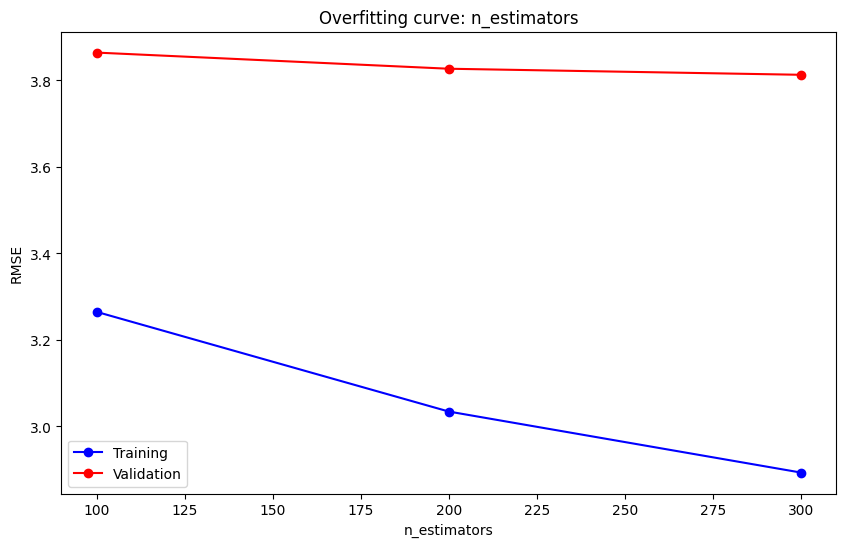

In [104]:

test_param_and_plot(XGBRegressor, 'n_estimators', [100, 200, 300], **best_params)

In [105]:
best_params['n_estimators'] = 300

### Max Depth

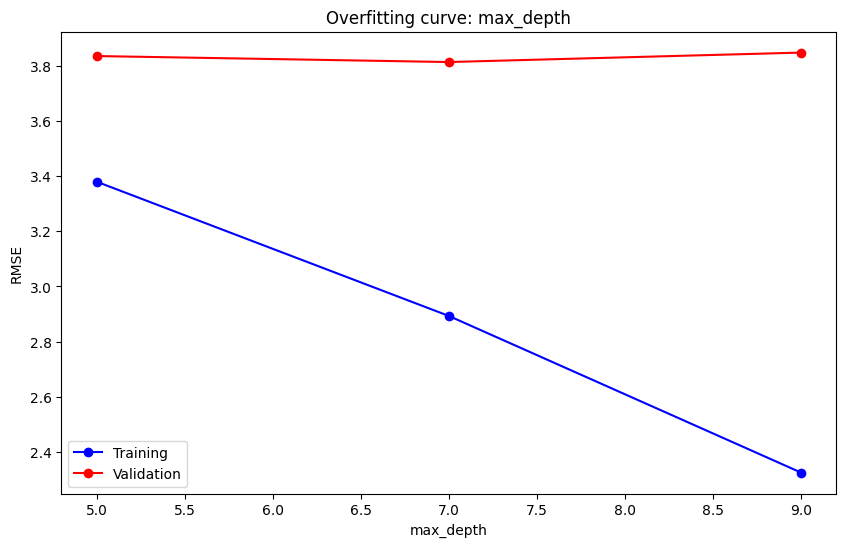

In [106]:

test_param_and_plot(XGBRegressor, 'max_depth', [5, 7, 9], **best_params)

In [100]:
best_params['max_depth'] = 7

### Learning Rate

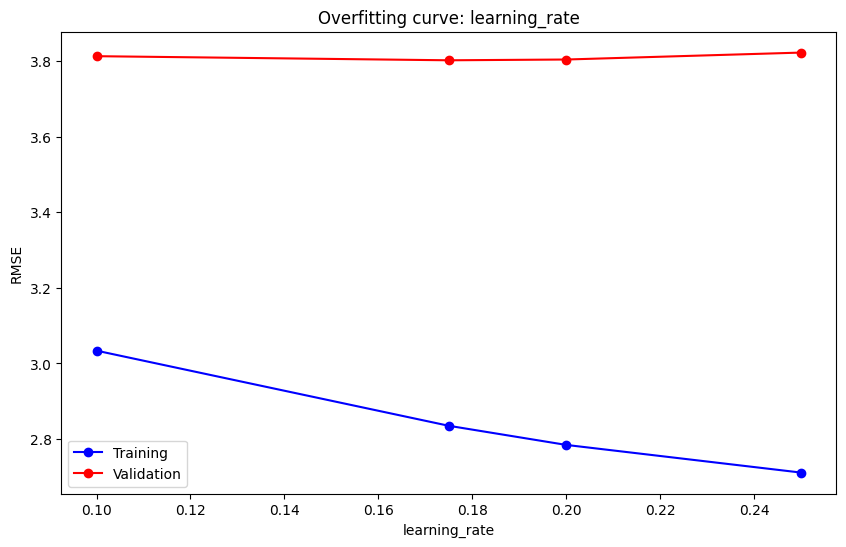

In [108]:

test_param_and_plot(XGBRegressor, 'learning_rate', [0.1,0.175,0.2, 0.25], **best_params)

In [109]:
best_params['learning_rate'] = 0.175

In [110]:
best_params

{'random_state': 42,
 'n_jobs': -1,
 'objective': 'reg:squarederror',
 'n_estimators': 300,
 'max_depth': 7,
 'learning_rate': 0.175}

### Other Parameters

Similarly we can experiment with other parameters. 

Here's a set of parameters that works well:

### Subsample


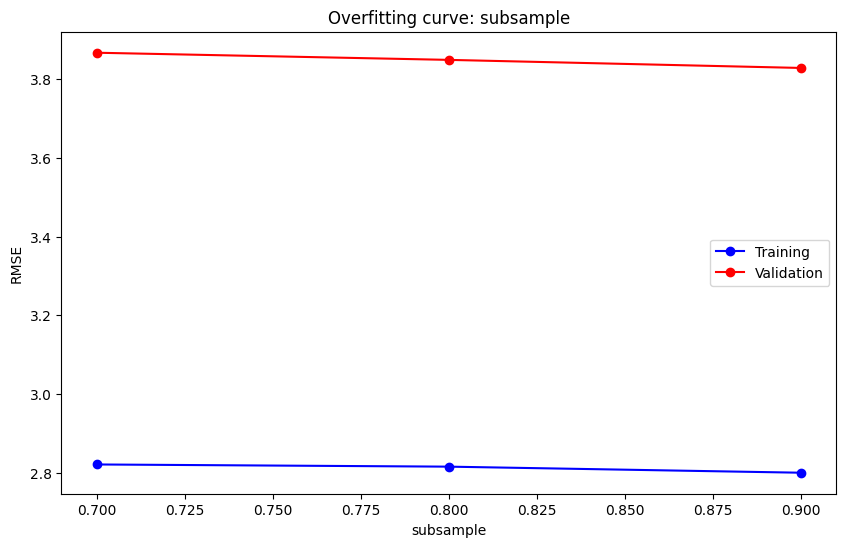

In [111]:
test_param_and_plot(XGBRegressor, 'subsample', [0.7,0.8,0.9], **best_params)

In [122]:
best_params['subsample'] = 0.9

In [123]:
xgb_model_final = XGBRegressor(**best_params).fit(train_inputs, train_targets)

In [119]:
evaluate(xgb_model_final)

(2.8350868225097656,
 3.801562786102295,
 array([4.394906 , 9.072462 , 6.540428 , ..., 7.3402944, 7.202623 ,
        7.8671193], shape=(780196,), dtype=float32),
 array([ 8.733402,  9.553196,  6.646313, ..., 10.40865 ,  6.158916,
        14.249126], shape=(195010,), dtype=float32))

In [120]:
predict_and_submit(xgb_model_final, test_inputs, 'xgb_tunedv1_sub.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.741094
1,2015-01-27 13:08:24.0000003,11.736364
2,2011-10-08 11:53:44.0000002,4.599907
3,2012-12-01 21:12:12.0000002,9.255515
4,2012-12-01 21:12:12.0000003,15.861878
...,...,...
9909,2015-05-10 12:37:51.0000002,8.964458
9910,2015-01-12 17:05:51.0000001,11.288215
9911,2015-04-19 20:44:15.0000001,55.127499
9912,2015-01-31 01:05:19.0000005,19.254494


In [121]:
best_params

{'random_state': 42,
 'n_jobs': -1,
 'objective': 'reg:squarederror',
 'n_estimators': 300,
 'max_depth': 7,
 'learning_rate': 0.175,
 'subsample': None}

## 9. Document & Publish Your Work

 TIP #13: Always document and publish your projects online. They help improving your understanding, showcase your skills & often lead to inbound job opportunities.
 
- Add explanations using Markdown
- Clean up the code & create functions
- Publish notebook to Jovian
- Write a blog post and embed

Follow this guide: https://www.youtube.com/watch?v=NK6UYg3-Bxs 

## References

* Dataset: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview
* Missing semester (Shell scripting): https://missing.csail.mit.edu/
* Opendatsets library: https://github.com/JovianML/opendatasets 
* EDA project from scratch: https://www.youtube.com/watch?v=kLDTbavcmd0
* GeoPy: https://geopy.readthedocs.io/en/stable/#module-geopy.distance 
* Blog post by Allen Kong: https://towardsdatascience.com/nyc-taxi-fare-prediction-605159aa9c24 
* Machine Learning with Python: Zero to GBMs - https://zerotogbms.com 
* Experiment tracking spreadsheet: https://bit.ly/mltrackingsheet 
* Pandas datetime components: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components 
* Haversine distance: https://en.wikipedia.org/wiki/Haversine_formula 
* Haversine distance with Numpy: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas 
* RAPIDS (parent project for cudf and cuml): https://rapids.ai/
* Data Science blog post from scratch: https://www.youtube.com/watch?v=NK6UYg3-Bxs 
* Examples of Machine Learning Projects:
    * Walmart Store Sales: https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm
    * Used Car Price Prediction: https://jovian.ai/kara-mounir/used-cars-prices 
    * Lithology Prediction: https://jovian.ai/ramysaleem/ml-project-machine-predicting-lithologies
    * Ad Demand Prediction: https://jovian.ai/deepa-sarojam/online-ad-demand-prediction-ml-prj 
    * Credit Scoring: https://jovian.ai/shenghongzhong/credit-scores-algorithms-ml-2